In [ ]:
import os
import re
import time
import pickle
import asyncio
import nest_asyncio
import pandas as pd
import numpy as np
import json
import logging
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
from typing import List, Dict, Any, Optional

from dotenv import load_dotenv
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA, LLMChain
from langchain.prompts import PromptTemplate
from langchain_community.embeddings import ClovaXEmbeddings
from langchain_community.chat_models import ChatClovaX
from pymilvus import connections, utility
from langchain_community.vectorstores.milvus import Milvus
from langchain.schema import BaseRetriever
from sklearn.metrics.pairwise import cosine_similarity
from pydantic import BaseModel, Field

from elasticsearch import Elasticsearch, helpers
from langchain_elasticsearch import ElasticsearchStore
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers.self_query.elasticsearch import ElasticsearchTranslator
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

In [9]:
# 로깅 설정
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

##### Custom Retriever

In [ ]:
class ISBNMergingRetriever(BaseRetriever):
    base_retriever: BaseRetriever

    def _get_relevant_documents(self, query: str) -> List[Document]:
        try:
            docs = self.base_retriever.get_relevant_documents(query)
        except Exception as e:
            logger.error(f" 기본 쿼리 retrieval 에러 '{query}': {e}", exc_info=True)
            logger.warning("빈 list 반환")
            docs = []

        grouped, merged_docs = {}, []
        for doc in docs:
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            if isbn == "NO_ISBN":
                continue
            grouped.setdefault(isbn, []).append(doc)
        for isbn, doc_list in grouped.items():
            combined_text = "\n".join(d.page_content for d in doc_list)
            merged_meta = dict(doc_list[0].metadata)
            logger.debug(
                f"[ISBN 병합] ISBN: {isbn}, Merged Chunks: {len(doc_list)}, Combined Text Length: {len(combined_text)}"
            )
            merged_docs.append(
                Document(page_content=combined_text, metadata=merged_meta)
            )

        logger.info(
            f"ISBN 기준으로 {len(grouped)} 그룹 병합 완료. 최종 문서 수: {len(merged_docs)}"
        )
        return merged_docs

    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        # 비동기 버전 - 로직은 동일, 추가 예외 처리
        try:
            docs = await self.base_retriever.aget_relevant_documents(query)
        except Exception as e:
            logger.error(
                f"기본 쿼리 retrieval 비동기 에러 '{query}': {e}", exc_info=True
            )
            logger.warning("빈 list 반환")
            docs = []

        grouped, merged_docs = {}, []
        for doc in docs:
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            if isbn == "NO_ISBN":
                continue
            grouped.setdefault(isbn, []).append(doc)
        for isbn, doc_list in grouped.items():
            combined_text = "\n".join(d.page_content for d in doc_list)
            merged_meta = dict(doc_list[0].metadata)
            logger.debug(
                f"[Async ISBN Merging] ISBN: {isbn}, Merged Chunks: {len(doc_list)}, Combined Text Length: {len(combined_text)}"
            )
            merged_docs.append(
                Document(page_content=combined_text, metadata=merged_meta)
            )
        logger.info(
            f"Async ISBN 기준으로 {len(grouped)} 그룹 병합 완료. 최종 문서 수: {len(merged_docs)}"
        )
        return merged_docs

    def add_documents(self, documents: List[Document], **kwargs) -> None:
        pass

    def get_type(self) -> str:
        return "isbn_merging_retriever"

In [11]:
# text는 아래와 같은 형태로 들어가서 청크

# 제목 : [값]
# 분류 : [값]
# 저자 : [값]
# 저자소개 : [값]
# 책 소개 : [값]
# 목차 : [값]
# 출판사리뷰 : [값]

# 임베딩 pkl에 포함된 메타데이터 컬럼과 (임베딩,원본text)로 묶인 컬럼

# 메타데이터 및 벡터 문서 컬럼 설정

# metadata_columns = [
#     "ISBN",
#     "페이지",
#     "가격",
#     "제목",
#     "부제",
#     "저자",
#     "분류",
#     "목차",
#     "발행자",
#     "표지",
# ]
# vector_doc_columns = [
#     "제목",
#     "부제",
#     "분류",
#     "저자",
#     "저자소개",
#     "책소개",
#     "출판사리뷰",
#     "추천사",
#     "목차",
# ]

##### Util Function

In [ ]:
# Helper functions
def is_similar_question(new_emb, prev_embeds, threshold=0.65):
    if not prev_embeds:
        return False
    sim_scores = cosine_similarity([new_emb], prev_embeds)[0]
    max_score = max(sim_scores)
    logger.info(f"[중복 유사도 판단] Max = {max_score:.3f}")
    return max_score > threshold


def extract_field(text, field_name):
    pattern = rf"^\s*{re.escape(field_name)}\s*:\s*(.*?)\s*$"
    lines = text.splitlines()
    for line in lines:
        match = re.search(pattern, line, re.IGNORECASE)
        if match:
            return match.group(1).strip()
    return ""

##### 환경설정 & 임베딩

In [ ]:
# 환경설정
load_dotenv(dotenv_path=r"C:\Kill_the_RAG\Project\Aiffel_final_project\.env")

api_key = os.getenv("NCP_CLOVASTUDIO_API_KEY")
api_url = os.getenv("NCP_CLOVASTUDIO_API_URL", "https://clovastudio.stream.ntruss.com/")
milvus_host = os.getenv("MILVUS_HOST", "localhost")
milvus_port = os.getenv("MILVUS_PORT", "19530")
es_url = os.getenv("ELASTICSEARCH_URL", "http://localhost:9200")
es_index_name = "book_bm25_index"

if not api_key:
    raise ValueError("NCP_CLOVASTUDIO_API_KEY 환경 변수가 설정되지 않았습니다.")
if not api_url:
    raise ValueError("NCP_CLOVASTUDIO_API_URL 환경 변수가 설정되지 않았습니다.")
if not es_url:
    raise ValueError("ELASTICSEARCH_URL 환경 변수가 설정되지 않았습니다.")

os.environ["NCP_CLOVASTUDIO_API_KEY"] = api_key
os.environ["NCP_CLOVASTUDIO_API_URL"] = api_url

try:
    ncp_embeddings = ClovaXEmbeddings(model="bge-m3")
    llm_clova = ChatClovaX(model="HCX-003", max_tokens=2048)
    logger.info("ClovaX Embeddings 및 Chat 모델 초기화 완료")
except Exception as e:
    logger.error(f"ClovaX 모델 초기화 실패: {e}")
    raise

2025-04-06 16:40:27,813 - INFO - ClovaX Embeddings 및 Chat 모델 초기화 완료


In [ ]:
embedding_file = r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\final_embedding\final_embedding.pkl"
if os.path.exists(embedding_file):
    try:
        with open(embedding_file, "rb") as f:
            saved_data = pickle.load(f)
        all_text_embedding_pairs = [
            (v["text"], v["embedding"]) for v in saved_data.values()
        ]
        all_metadata_list = [v["metadata"] for v in saved_data.values()]
        logger.info(f"임베딩 데이터 로드 완료: {len(all_text_embedding_pairs)}개")
    except Exception as e:
        logger.error(f"임베딩 파일 로드 실패: {e}")
        raise
else:
    raise FileNotFoundError(f"임베딩 파일을 찾을 수 없습니다: {embedding_file}")

# 메타데이터 매핑
metadata_mapping = {
    "ISBN": "ISBN",
    "페이지": "page",
    "가격": "price",
    "제목": "title",
    "부제": "subtitle",
    "저자": "author",
    "분류": "category",
    "저자소개": "author_intro",
    "책소개": "book_intro",
    "목차": "table_of_contents",
    "출판사리뷰": "publisher_review",
    "추천사": "recommendation",
    "발행자": "publisher",
    "표지": "book_cover",
}


# 부제/NA값 클리닝 함수
def clean_metadata(meta: dict) -> dict:
    cleaned = {}

    target_keys = [
        "ISBN",
        "page",
        "price",
        "title",
        "subtitle",
        "author",
        "category",
        "author_intro",
        "book_intro",
        "table_of_contents",
        "publisher_review",
        "recommendation",
        "publisher",
        "book_cover",
    ]

    original_to_target = {
        k_orig: k_target for k_orig, k_target in metadata_mapping.items()
    }

    for target_key in target_keys:
        original_key = next(
            (k for k, v in original_to_target.items() if v == target_key), None
        )

        value = (
            meta.get(original_key)
            if original_key and original_key in meta
            else meta.get(target_key)
        )

        if target_key == "subtitle" and not isinstance(value, str):
            cleaned[target_key] = "" if pd.isna(value) else str(value)
        elif target_key in ["page", "price"]:
            try:
                cleaned[target_key] = int(value) if not pd.isna(value) else 0
            except (ValueError, TypeError):
                cleaned[target_key] = 0
        else:
            cleaned[target_key] = "" if pd.isna(value) else str(value)
    return cleaned


# Document 생성
documents = []
for pair, meta in zip(all_text_embedding_pairs, all_metadata_list):
    cleaned_meta = clean_metadata(meta)
    documents.append(Document(page_content=pair[0], metadata=cleaned_meta))

logger.info(f"총 {len(documents)}개의 Document 객체 생성 완료.")
texts = [doc.page_content for doc in documents]
embeds = [pair[1] for pair in all_text_embedding_pairs]
metadatas = [doc.metadata for doc in documents]

2025-04-06 16:41:28,477 - INFO - 임베딩 데이터 로드 완료: 116218개
2025-04-06 16:41:32,692 - INFO - 총 116218개의 Document 객체 생성 완료.


In [ ]:
# Milvus Vector Store 설정
collection_name = "book_rag_db_v2"
temp_conn_alias = "utility_check_conn"
try:
    connections.connect(alias=temp_conn_alias, host=milvus_host, port=milvus_port)
    logger.info(
        f"Milvus 유틸리티 함수용 임시 연결 설정 완료 (alias: {temp_conn_alias})."
    )
    if utility.has_collection(collection_name, using=temp_conn_alias):
        logger.warning(f"기존 Milvus 컬렉션 '{collection_name}'을 삭제합니다.")
        utility.drop_collection(collection_name, using=temp_conn_alias)
    else:
        logger.info(f"Milvus 컬렉션 '{collection_name}'이(가) 존재하지 않습니다.")
except Exception as e:
    logger.error(f"Milvus 유틸리티 함수 실행 중 오류 발생: {e}", exc_info=True)
finally:
    try:
        if connections.get_connection_addr(temp_conn_alias):
            connections.disconnect(temp_conn_alias)
            logger.info(
                f"Milvus 유틸리티 함수용 임시 연결 해제 완료 (alias: {temp_conn_alias})."
            )
    except Exception as disconnect_e:
        logger.warning(f"Milvus 임시 연결 해제 중 오류 (무시 가능): {disconnect_e}")

try:
    vectorstore = Milvus(
        embedding_function=ncp_embeddings,
        collection_name=collection_name,
        connection_args={"host": milvus_host, "port": milvus_port},
        auto_id=True,
    )
    logger.info(
        f"Langchain Milvus 인스턴스 초기화 및 연결 설정 완료 (컬렉션: '{collection_name}')."
    )

    original_embed_documents = ClovaXEmbeddings.embed_documents

    def precomputed_embed_documents(cls, input_texts):

        if len(input_texts) == len(texts):
            return embeds
        else:
            logger.warning("임베딩 미스매치")
            return original_embed_documents(cls, input_texts)

    ClovaXEmbeddings.embed_documents = classmethod(precomputed_embed_documents)
    vectorstore.add_texts(texts=texts, metadatas=metadatas)
    logger.info(f"Milvus에 {len(texts)}개의 텍스트와 임베딩 추가 완료.")

    ClovaXEmbeddings.embed_documents = original_embed_documents

except Exception as e:
    logger.error(f"Milvus 데이터 추가 중 오류 발생: {e}", exc_info=True)
    if (
        "original_embed_documents" in locals()
        and ClovaXEmbeddings.embed_documents != original_embed_documents
    ):
        ClovaXEmbeddings.embed_documents = original_embed_documents
    raise

2025-04-06 16:41:34,006 - INFO - Milvus 유틸리티 함수용 임시 연결 설정 완료 (alias: utility_check_conn).
2025-04-06 16:41:34,055 - INFO - Milvus 컬렉션 'book_rag_db_v2'이(가) 존재하지 않습니다.
2025-04-06 16:41:34,175 - INFO - Milvus 유틸리티 함수용 임시 연결 해제 완료 (alias: utility_check_conn).
C:\Users\computer\AppData\Local\Temp\ipykernel_35088\1032522646.py:23: LangChainDeprecationWarning: The class `Milvus` was deprecated in LangChain 0.2.0 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-milvus package and should be used instead. To use it run `pip install -U :class:`~langchain-milvus` and import as `from :class:`~langchain_milvus import MilvusVectorStore``.
  vectorstore = Milvus(
2025-04-06 16:41:34,287 - INFO - Langchain Milvus 인스턴스 초기화 및 연결 설정 완료 (컬렉션: 'book_rag_db_v2').
2025-04-06 16:43:15,946 - INFO - Milvus에 116218개의 텍스트와 임베딩 추가 완료.


In [ ]:
# Elasticsearch Store 설정
try:
    logger.info(f"Elasticsearch 연결중 {es_url}...")
    es_client = Elasticsearch(
        hosts=[es_url],
        request_timeout=120,  # timeout
        # basic_auth, api_key 가 필요하면,
        # basic_auth=("user", "password"),
        # api_key=("id", "key"), 등
    )

    if not es_client.ping():
        raise ConnectionError("Elasticsearch 연결 실패")
    logger.info("Elasticsearch 연결 성공")

    if es_client.indices.exists(index=es_index_name):
        logger.warning(f"기존 Elasticsearch 인덱스 '{es_index_name}' 삭제 중...")
        es_client.indices.delete(index=es_index_name, ignore=[400, 404])
        logger.info(f"기존 Elasticsearch 인덱스 '{es_index_name}' 삭제 완료.")
    else:
        logger.info(
            f"Elasticsearch 인덱스 '{es_index_name}' 존재하지 않음. 새로 생성됩니다."
        )

    # ElasticsearchStore 초기화
    es_store = ElasticsearchStore(
        index_name=es_index_name,
        embedding=ncp_embeddings,
        es_connection=es_client,
        strategy=ElasticsearchStore.ApproxRetrievalStrategy(hybrid=False),
    )
    logger.info(
        f"Langchain ElasticsearchStore 인스턴스 초기화 완료 (인덱스: '{es_index_name}')."
    )

    # Elasticsearch 인덱싱
    logger.info(f"Elasticsearch에 문서 인덱싱 시작 (총 {len(texts)}개)...")

    actions = [
        {
            "_index": es_index_name,
            # "_id": doc.metadata.get("ISBN", f"doc_{i}"), # 옵션으로
            "_source": {"text": texts[i], **metadatas[i]},  # text원본 & metadata
        }
        for i in range(len(texts))
    ]

    # 한번에 bulk로 처리
    indexed_count, errors = helpers.bulk(es_client, actions, raise_on_error=False)
    logger.info(f"Elasticsearch 벌크 인덱싱 시도 완료: {indexed_count} 문서 성공.")
    if errors:
        logger.error(f"Elasticsearch 벌크 인덱싱 중 오류 발생: {len(errors)}개 실패.")
        for i, error in enumerate(errors[:5]):
            logger.error(f"  오류 {i+1}: {error}")

    es_client.indices.refresh(index=es_index_name)
    logger.info(f"Elasticsearch 인덱스 '{es_index_name}' 새로고침 완료.")

except ConnectionError as ce:
    logger.error(f"Elasticsearch 연결 실패: {ce}")
    raise
except Exception as e:
    logger.error(
        f"Elasticsearch 설정 또는 데이터 추가 중 오류 발생: {e}", exc_info=True
    )
    raise

2025-04-06 16:44:56,229 - INFO - Connecting to Elasticsearch at http://localhost:9200...
2025-04-06 16:44:56,355 - INFO - HEAD http://localhost:9200/ [status:200 duration:0.124s]
2025-04-06 16:44:56,355 - INFO - Successfully connected to Elasticsearch.
2025-04-06 16:44:56,361 - INFO - HEAD http://localhost:9200/book_bm25_index [status:404 duration:0.005s]
2025-04-06 16:44:56,361 - INFO - Elasticsearch 인덱스 'book_bm25_index' 존재하지 않음. 새로 생성됩니다.
2025-04-06 16:44:56,363 - INFO - Langchain ElasticsearchStore 인스턴스 초기화 완료 (인덱스: 'book_bm25_index').
2025-04-06 16:44:56,363 - INFO - Elasticsearch에 문서 인덱싱 시작 (총 116218개)...
2025-04-06 16:45:03,682 - INFO - PUT http://localhost:9200/_bulk [status:200 duration:7.141s]
2025-04-06 16:45:04,532 - INFO - PUT http://localhost:9200/_bulk [status:200 duration:0.823s]
2025-04-06 16:45:05,060 - INFO - PUT http://localhost:9200/_bulk [status:200 duration:0.505s]
2025-04-06 16:45:06,612 - INFO - PUT http://localhost:9200/_bulk [status:200 duration:1.529s]
2025-

In [ ]:
# Retriever 설정

# 1. Dense Retriever (Milvus)
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})
logger.info("Dense retriever (Milvus) 설정 완료.")

# 2. Sparse Retriever
metadata_field_info = [
    AttributeInfo(name="title", description="The title of the book", type="string"),
    AttributeInfo(
        name="category",
        description="The category of the book (e.g., 소설, 과학, 역사)",
        type="string",
    ),
    AttributeInfo(name="author", description="The author of the book", type="string"),
    AttributeInfo(
        name="page", description="The number of pages in the book", type="integer"
    ),
    AttributeInfo(name="price", description="The price of the book", type="integer"),
    AttributeInfo(
        name="publisher", description="The publisher of the book", type="string"
    ),
]
document_contents = "Information about a book, including title, author, introduction, table of contents, and reviews."

try:
    sparse_selfquery_retriever = SelfQueryRetriever.from_llm(
        llm=llm_clova,
        vectorstore=es_store,
        document_contents=document_contents,
        metadata_field_info=metadata_field_info,
        structured_query_translator=ElasticsearchTranslator(),
        verbose=True,
    )
    sparse_selfquery_retriever.search_kwargs = {"k": 10}
    logger.info("Sparse self-query retriever (Elasticsearch) 설정 완료.")

except Exception as e:
    logger.error(f"SelfQueryRetriever 설정 중 오류 발생: {e}", exc_info=True)
    logger.warning("SelfQueryRetriever 설정 실패. 기본 Elasticsearch retriever 사용.")
    es_retriever_basic = es_store.as_retriever(
        search_type="similarity", search_kwargs={"k": 10}
    )


# 3. Hybrid Retriever - Ensemble
hybrid_retriever = EnsembleRetriever(
    retrievers=[sparse_selfquery_retriever, dense_retriever], weights=[0.5, 0.5]
)
logger.info("Hybrid ensemble retriever 설정 완료.")

# 4. Final Retriever with ISBN Merging
merged_hybrid_retriever = ISBNMergingRetriever(base_retriever=hybrid_retriever)
logger.info("ISBN Merging Retriever 설정 완료 (Hybrid 기반).")

# 5.
dpr_qa_chain = RetrievalQA.from_chain_type(
    llm=llm_clova,
    retriever=merged_hybrid_retriever,
    return_source_documents=True,
)
logger.info("RetrievalQA 체인 설정 완료 (Merged Hybrid Retriever 사용).")

MIN_INFO_LENGTH = 10
previous_additional_question_embeddings = []

2025-04-06 16:58:46,489 - INFO - Dense retriever (Milvus) 설정 완료.
2025-04-06 16:58:46,560 - INFO - Sparse self-query retriever (Elasticsearch) 설정 완료.
2025-04-06 16:58:46,562 - INFO - Hybrid ensemble retriever 설정 완료.
2025-04-06 16:58:46,563 - INFO - ISBN Merging Retriever 설정 완료 (Hybrid 기반).
2025-04-06 16:58:46,572 - INFO - RetrievalQA 체인 설정 완료 (Merged Hybrid Retriever 사용).


#####  Retriever 및 QA 체인

##### Prompt

In [19]:
# 1. 사용자 선호도 추출 프롬프트
extract_pref_prompt_v2 = PromptTemplate(
    input_variables=["text"],
    template="""
다음 사용자 발화에서 사용자의 선호도 및 책에 대한 요구사항을 아래 JSON 형식으로 추출해라. 각 항목은 관련된 정보가 명확할때만 포함하고, 없다면 빈 리스트 `[]` 또는 빈 문자열 `""`로 남겨라. 여러개가 추출될 수 있는 항목은 리스트로 추출하라.

입력: {{ text }}

출력 형식 (JSON, 다른 설명 없이 JSON만 출력):
{
    "title": [<!-- 추출된 책 제목 -->],
    "author": [<!-- 추출된 책 저자 -->],
    "category": [<!-- 추출된 책 카테고리/장르 -->],
    "author_intro": [<!-- 저자 특성 언급/요구사항 -->],
    "book_intro": [<!-- 줄거리 관련 언급/요구사항 -->],
    "table_of_contents": [<!-- 세부적인 키워드 언급/요구사항 -->],
    "purpose": [<!-- 사용자의 독서 목적/이유 목록 (예: '재미', '학습', '시간 때우기', '기분') -->],
    "implicit info": [<!-- 추천해야 할 책에 대한 암시적 정보/특징/분위기 목록 (예: '밝은 분위기', '특정 상황에 어울리는 책', '최신 기술 동향') -->]
}
""",
    template_format="jinja2",  # 변수 치환을 위한 탬플릿
)

# 2. 선호도 통합 프롬프트
consolidate_pref_prompt = PromptTemplate(
    input_variables=["existing_preferences", "new_preferences"],
    template="""
기존에 수집된 사용자 선호도 정보와 새로 추출된 선호도 정보가 주어졌다. 두 정보를 지능적으로 통합하여 중복을 제거하고 관련 내용을 요약/결합하여 최종 선호도 목록을 생성해라.

[기존 선호도]
{{ existing_preferences }}

[새로운 선호도]
{{ new_preferences }}

[통합된 최종 선호도 목록]
(아래 목록 형태로만 출력, 각 항목은 문자열 리스트)
- 항목1: ["통합 내용1", "통합 내용2"]
- 항목2: ["통합 내용3"]
...
""",
    template_format="jinja2",
)

# 3. Decision Prompt
decision_prompt_template = PromptTemplate(
    template="""
[대화 맥락]
사용자 대화 내역:
{{ history }}
사용자의 최신 질문: "{{ query }}"
수집된 사용자 선호도:
{{ preferences }}

[역할 및 목표]
{{ role_instructions }}
현재 대화 상황, 질문, 수집된 선호도를 분석하여 아래 두 가지 행동 중 하나만 결정하고 필요한 정보를 생성하라.
- "추천": 사용자가 명시적으로 추천을 요청했거나, 사용자의 선호도 정보(카테고리, 저자, 목적, 분위기 등)를 반드시 3개 이상 수집했을 때만 추천에 들어가라.
- "추가 질문": 추천하기에 정보가 부족하거나 모호할 때, **아직 수집되지 않았거나 더욱 구체적인 선호도 정보**를 얻기 위한 질문 생성. (예: 어떤 장르를 선호하시나요? 특정 작가를 찾으시나요? 책을 읽는 목적이 무엇인가요?)

[출력 형식] (반드시 아래 형식만 정확히 따를 것)
행동: <추천 또는 추가 질문>
추가 질문: <"추가 질문" 행동일 경우 구체적인 질문 생성, "추천" 행동일 경우 빈 문자열>
""",
    input_variables=["history", "query", "preferences", "role_instructions"],
    template_format="jinja2",
)

# 4. Final Query Generation Prompt
final_query_generation_template = PromptTemplate(
    template="""
[대화 요약]
{{ history }}

[사용자 요청]
{{ query }}

[페르소나 정보]
{{ persona_info }}

[사용자 선호도 요약]
{{ preferences }}

위 정보를 전부 활용하여, 도서 검색에 가장 유용한 **핵심 키워드 중심의 최종 검색 쿼리**를 한 문장으로 작성하라.
오직 검색 쿼리 문장만 출력하라.
""",
    input_variables=["history", "query", "persona_info", "preferences"],
    template_format="jinja2",
)

# 5. Refine Prompt - 추후 더 업데이트를 통해 정제 기능 활성화
refine_prompt = PromptTemplate(
    input_variables=["query"],
    template="""주어진 검색 쿼리를 분석하여, 검색 엔진이나 다음 단계에서 사용하기 좋은 명확하고 간결한 단일 문장으로 정제해라. 불필요한 설명 없이 오직 정제된 쿼리 문장만 출력해라.

- "~~비슷한", "~ 같은", "~ 분위기의" 라고 사용자가 언급하면, 해당 책/저자의 **특징(예: 장르, 분위기, 핵심 소재, 작가 스타일)**을 반영하여 확장하라. 책 제목이나 저자 이름은 절대 직접 포함하지 마라.
- 예시 (입력: 해리포터 시리즈물같은 판타지 소설 알려줘) ->
1. 마법학교 배경의 청소년 판타지 소설 추천
2. 선과 악의 대결을 다룬 영국 판타지 시리즈
3. 성장 서사를 담은 인기 판타지 소설

[원본 검색 쿼리]
{{ query }}

[정제된 검색 쿼리]
""",
    template_format="jinja2",
)

# 6. Query Expansion Prompt
query_expansion_prompt = PromptTemplate(
    input_variables=["query"],
    template="""주어진 원본 검색 쿼리를 바탕으로, 관련성이 높으면서도 다양한 측면을 탐색할 수 있는 확장된 검색 쿼리 3개를 생성해라. 확장된 쿼리는 원본 쿼리의 핵심 의도를 반드시 유지해야 한다. 다른 설명이나 서론 없이, 오직 번호(1., 2., 3.)가 매겨진 확장 쿼리 목록만 한 줄에 하나씩 출력해라.

[원본 검색 쿼리]
{{ query }}

[확장된 검색 쿼리 목록]
""",
    template_format="jinja2",
)

# 7. Re_ranking Prompt
re_ranking_prompt = PromptTemplate(
    input_variables=["query", "documents"],
    template="""사용자의 검색 쿼리는 다음과 같습니다: "{{ query }}"
다음은 검색된 도서 목록입니다 (내용은 일부만 표시됨):
{% for doc in documents %}
{{ loop.index }}. 제목: {{ doc.metadata.get('title', '제목 없음') }}, 저자: {{ doc.metadata.get('author', '저자 없음') }}, 내용 일부: {{ doc.page_content | truncate(200) }}
{% endfor %}

위 검색 결과를 사용자의 검색 쿼리 "{{ query }}"와의 관련성, 그리고 문서 내용의 충실도를 종합적으로 고려하여 가장 적합한 순서대로 재배치하라.
가장 관련성이 높은 도서를 목록의 맨 위에 배치하고, 순위가 매겨진 **도서 제목과 저자**만으로 결과를 다음 형식으로 출력하라.

[출력 형식 예시]
1. 제목: <가장 관련성 높은 책 제목>, 저자: <저자 이름>
2. 제목: <두 번째 관련성 높은 책 제목>, 저자: <저자 이름>
...

[리랭킹된 도서 목록]
""",
    template_format="jinja2",
)

# 8. HyDE Generation Prompt
hyde_generation_prompt = PromptTemplate(
    input_variables=["query"],
    template="""다음 검색 쿼리에 완벽하게 부합하는 **이상적인 가상의 책**에 대한 **간결한 요약(1-2 문장)**을 생성해라. 이 요약은 해당 쿼리로 책을 찾는 사용자가 가장 만족할 만한 내용을 담고 있어야 한다. 오직 생성된 요약 텍스트만 출력하라.

[검색 쿼리]
{{ query }}

[가상의 책 요약]
""",
    template_format="jinja2",
)

# 9. Persona prompt
literature_role = "너는 감성적이고 문학적인 도서 추천 챗봇이다. 사용자의 감정과 취향을 깊이 이해하고 공감하며, 문학적인 표현을 사용하여 책을 추천해라."
science_role = "너는 정확하고 논리적인 과학/기술 도서 추천 챗봇이다. 사용자의 지식 수준과 관심 분야를 파악하고, 최신 정보와 기술 동향을 반영하여 체계적으로 책을 추천해라."
general_role = "너는 친절하고 신뢰할 수 있는 범용 도서 추천 챗봇이다. 다양한 분야의 책에 대해 균형 잡힌 시각으로 정보를 제공하고, 사용자의 요구사항에 맞춰 명확하고 이해하기 쉽게 책을 추천해라."


# 10. hyde_keyword_prompt

hyde_keyword_prompt = PromptTemplate(
    input_variables=["hyde_summary"],
    template="""다음은 사용자의 질문에 이상적으로 부합하는 가상의 책 요약입니다:
"{{ hyde_summary }}"

이 요약 내용에서 **핵심 키워드 5개**를 추출하여 쉼표(,)로 구분하여 나열해라. 오직 키워드 목록만 출력하라.

[핵심 키워드 목록]
""",
    template_format="jinja2",
)

##### Async Invoke function

In [ ]:
async def async_invoke(chain: LLMChain, vars_dict: dict, step_name: str) -> dict:
    try:
        logger.debug(
            f"[{step_name}] Chain 호출 시작. 입력 변수 일부: { {k: v[:100] + '...' if isinstance(v, str) and len(v) > 100 else v for k, v in vars_dict.items()} }"
        )
        result = await asyncio.to_thread(chain.invoke, vars_dict)
        result_text = result.get("text", "")
        logger.debug(
            f"[{step_name}] Chain 호출 완료. 결과 일부: {result_text[:200] + '...' if len(result_text) > 200 else result_text}"
        )
        return result
    except Exception as e:
        logger.error(f"[{step_name}] Chain 호출 중 예외 발생: {e}", exc_info=True)
        return {"text": ""}


async def async_invoke_llm(prompt: str, step_name: str) -> str:
    try:
        logger.debug(
            f"[{step_name}] LLM 호출 시작. 프롬프트 일부: {prompt[:200] + '...' if len(prompt) > 200 else prompt}"
        )
        response = await asyncio.to_thread(llm_clova.invoke, prompt)
        if hasattr(response, "content"):
            result_text = response.content.strip()
        elif hasattr(response, "text"):
            result_text = response.text().strip()
        else:
            result_text = str(response).strip()
        logger.debug(
            f"[{step_name}] LLM 호출 완료. 응답 일부: {result_text[:200] + '...' if len(result_text) > 200 else result_text}"
        )
        return result_text
    except Exception as e:
        logger.error(f"[{step_name}] LLM 호출 중 예외 발생: {e}", exc_info=True)
        return ""


# Weighted 함수
def weighted_sort(
    docs: List[Document], preferences: Dict[str, List[str]]
) -> List[Document]:
    """Sort documents based on preference matching."""

    def score(doc):
        s = 0.0
        author_pref = [p.lower() for p in preferences.get("author", [])]
        doc_author = doc.metadata.get("author", "").lower()
        if author_pref and any(pref_a in doc_author for pref_a in author_pref):
            s += 0.3

        category_pref = [p.lower() for p in preferences.get("category", [])]
        doc_category = doc.metadata.get("category", "").lower()
        if category_pref and any(
            pref_c == doc_category or pref_c in doc_category for pref_c in category_pref
        ):
            s += 0.2

        implicit_pref = [p.lower() for p in preferences.get("implicit info", [])]
        if implicit_pref:
            content_lower = doc.page_content.lower()
            for keyword in implicit_pref:
                if keyword in content_lower:
                    s += 0.1
        return s

    return sorted(docs, key=score, reverse=True)

##### Weighting Fucntion - 추후 페르소나별로 다르게 적용할 수 있다면?

In [15]:
def weighted_sort(
    docs: List[Document], preferences: Dict[str, List[str]]
) -> List[Document]:
    """집중해야할 field 별로 or 선호도 별로 청크 리랭킹 점수에에"""

    def score(doc):
        s = 0.0
        author_pref = preferences.get("author", [])

        if author_pref and doc.metadata.get("author") in author_pref:
            s += 0.3  # 저자 일치 시
        category_pref = preferences.get("category", [])
        if category_pref and doc.metadata.get("category") in category_pref:
            s += 0.2  # 카테고리 일치 시

        # implicit info의 점수화
        implicit_pref = preferences.get("implicit info", [])
        if implicit_pref:
            content_lower = doc.page_content.lower()
            for keyword in implicit_pref:
                if keyword.lower() in content_lower:
                    s += 0.1  # 암시적 정보 키워드 포함 시 약간의 가중치
        return s

    # 점수가 높은 순으로 정렬, 점수가 같으면 원래 순서 유지
    return sorted(docs, key=score, reverse=True)

##### Base RAG Pipeline

In [ ]:
# --- BaseRAGPipeline Class ---
class BaseRAGPipeline:
    def __init__(
        self, config, llm, embeddings, vectorstore, es_store, retriever, documents
    ):
        self.config = config
        self.llm = llm
        self.embeddings = embeddings
        self.vectorstore = vectorstore  # Milvus Vectorstore
        self.es_store = es_store  # Elasticsearch Store
        self.retriever = retriever
        # self.qa_chain = qa_chain
        self.documents = documents

        self.user_history: List[str] = []
        self.llm_history: List[str] = []
        self.user_preferences: Dict[str, List[str]] = {
            "title": [],
            "author": [],
            "category": [],
            "author_intro": [],
            "book_intro": [],
            "table_of_contents": [],
            "purpose": [],
            "implicit info": [],
        }
        self.preferences_text: str = ""
        self.preference_update_count: int = 0
        self.last_recommendations: List[Document] = []
        self.last_action: Optional[str] = None

        # LLM Chains
        self.extract_pref_chain = LLMChain(llm=self.llm, prompt=extract_pref_prompt_v2)
        # self.consolidate_pref_chain = LLMChain(llm=self.llm, prompt=consolidate_pref_prompt) # LLM consolidation logic removed for simplicity
        self.decision_chain = LLMChain(llm=self.llm, prompt=decision_prompt_template)
        self.final_query_generation_chain = LLMChain(
            llm=self.llm, prompt=final_query_generation_template
        )
        self.refine_chain = LLMChain(llm=self.llm, prompt=refine_prompt)
        self.query_expansion_chain = LLMChain(
            llm=self.llm, prompt=query_expansion_prompt
        )
        self.re_ranking_chain = LLMChain(llm=self.llm, prompt=re_ranking_prompt)
        self.hyde_generation_chain = LLMChain(
            llm=self.llm, prompt=hyde_generation_prompt
        )
        self.hyde_keyword_chain = LLMChain(llm=self.llm, prompt=hyde_keyword_prompt)

    def robust_parse_decision_response(
        self, response_text: str
    ) -> tuple[Optional[str], str]:
        action_match = re.search(r'행동\s*[:：]\s*"?([^"\n]+)"?', response_text)
        action = action_match.group(1).strip() if action_match else None
        follow_match = re.search(r'추가\s*질문\s*[:：]\s*"?([^"\n]+)"?', response_text)
        additional_question = follow_match.group(1).strip() if follow_match else ""
        if not action:
            logger.warning(
                f"행동 결정 파싱 실패: '{response_text}'. 기본 '추가 질문'으로 처리."
            )
            return "추가 질문", additional_question
        logger.info(
            f"행동 결정 파싱 결과: 행동='{action}', 추가 질문='{additional_question}'"
        )
        return action, additional_question

    async def update_preferences_from_input(self, user_input: str) -> None:
        logger.info(f"사용자 입력에서 선호도 추출 시작: '{user_input[:100]}...'")
        extract_result = await async_invoke(
            self.extract_pref_chain, {"text": user_input}, "선호도 추출"
        )
        extracted_text = extract_result.get("text", "{}")
        extracted_prefs: Dict[str, List[str]] = {}
        try:
            json_match = re.search(r"\{.*\}", extracted_text, re.DOTALL)
            if json_match:
                extracted_prefs_raw = json.loads(json_match.group(0))
            else:
                logger.warning(
                    f"선호도 추출 결과에서 JSON 객체를 찾을 수 없음: {extracted_text}"
                )
                extracted_prefs_raw = {}

            defined_keys = self.user_preferences.keys()
            for key, value in extracted_prefs_raw.items():
                if key in defined_keys:
                    vals_to_add = []
                    if isinstance(value, list):
                        vals_to_add = [str(item) for item in value if item]
                    elif isinstance(value, str) and value:
                        vals_to_add = [value]
                    extracted_prefs[key] = vals_to_add
                else:
                    logger.warning(
                        f"추출된 선호도 키 '{key}'가 정의된 형식에 없음. 무시."
                    )
            logger.info(
                f"추출 및 정제된 선호도: {json.dumps(extracted_prefs, ensure_ascii=False)}"
            )

        except json.JSONDecodeError as e:
            logger.error(
                f"선호도 추출 결과 JSON 파싱 실패: {e}. 원본 텍스트: {extracted_text}"
            )

        if not extracted_prefs:
            logger.info("새로 추출된 유효한 선호도 정보가 없음")
            return

        updated_something = False
        for key, new_values in extracted_prefs.items():
            if new_values:
                existing_values_set = set(self.user_preferences.get(key, []))
                added_values = [v for v in new_values if v not in existing_values_set]
                if added_values:
                    self.user_preferences[key].extend(added_values)
                    self.user_preferences[key] = sorted(
                        list(set(self.user_preferences[key]))
                    )
                    updated_something = True
                    logger.info(
                        f"선호도 업데이트됨 [{key}]: {self.user_preferences[key]}"
                    )

        if updated_something:
            self.preference_update_count += 1
            logger.info(
                f"선호도 업데이트 완료. 누적 업데이트 횟수: {self.preference_update_count}"
            )
        else:
            logger.info("기존 선호도에서 변경된 내용 없음.")

        pref_items = []
        display_key_map = {
            "title": "관련 제목",
            "author": "관련 저자",
            "category": "선호 장르/분류",
            "author_intro": "저자 관련 요구",
            "book_intro": "내용 관련 요구",
            "table_of_contents": "목차 관련 요구",
            "purpose": "독서 목적",
            "implicit info": "책에 대한 암시적 요구",
        }
        for key, values in self.user_preferences.items():
            if values:
                display_key = display_key_map.get(key, key)
                pref_items.append(f"- {display_key}: {', '.join(values)}")
        self.preferences_text = (
            "\n".join(pref_items) if pref_items else "수집된 선호도 없음"
        )
        logger.debug(f"업데이트된 선호도 요약 텍스트:\n{self.preferences_text}")

    async def get_final_query(self, current_user_query: str) -> str:
        logger.info("최종 검색 쿼리 생성 시작")
        persona = self.config.get("persona")
        persona_info_map = {
            "Literature": "감성, 현재 기분, 선호하는 문학 장르 및 작가 정보",
            "Science": "초심자 여부, 관심 분야, 구체적인 기술 정보",
            "General": "장르, 책을 찾는 이유, 독서 취향 정보",
        }
        persona_info = persona_info_map.get(persona, persona_info_map["General"])

        final_query_vars = {
            "history": "\n".join(self.user_history[-5:]),
            "query": current_user_query,
            "persona_info": persona_info,
            "preferences": self.preferences_text,
        }

        result_gen = await async_invoke(
            self.final_query_generation_chain, final_query_vars, "선호도 종합 쿼리 생성"
        )
        generated_query = result_gen.get("text", "").strip()
        logger.info(f"LLM 생성 쿼리 (정제 전): '{generated_query}'")

        query_to_use = generated_query
        if generated_query:
            refine_result = await async_invoke(
                self.refine_chain, {"query": generated_query}, "쿼리 정제"
            )
            refined_query = refine_result.get("text", "").strip().strip('"')
            logger.info(f"정제된 쿼리: '{refined_query}'")

            negative_keywords = [
                "없",
                "못",
                "않",
                "오류",
                "잘못",
                "알 수 없",
                "쿼리",
                "입력",
                "죄송",
            ]
            is_invalid_refinement = (
                not refined_query
                or len(refined_query) < 5
                or refined_query == generated_query
                or any(keyword in refined_query for keyword in negative_keywords)
                or "{" in refined_query
                or "}" in refined_query
            )

            if is_invalid_refinement:
                logger.warning(
                    f"정제된 쿼리('{refined_query}')가 유효하지 않아 정제 전 쿼리('{generated_query}') 사용."
                )
            else:
                query_to_use = refined_query
        else:
            logger.warning("선호도 종합 쿼리 생성 실패. 원본 사용자 쿼리를 사용.")
            query_to_use = current_user_query

        if not query_to_use or len(query_to_use) < 5:
            logger.warning(
                f"최종 결정된 쿼리('{query_to_use}')가 너무 짧아 원본 사용자 쿼리('{current_user_query}') 사용."
            )
            query_to_use = current_user_query

        if re.search(
            r"\b(eq|ne|gt|gte|lt|lte|contain|like)\b", query_to_use, re.IGNORECASE
        ):
            logger.warning(
                f"Potential self-query syntax detected in final query: '{query_to_use}'. Using original query: '{current_user_query}'"
            )
            query_to_use = current_user_query

        logger.info(f"최종 결정된 검색 쿼리: '{query_to_use}'")
        return query_to_use

    async def _summarize_chunk_with_llm(self, text: str) -> str:
        if not text or len(text.strip()) < MIN_INFO_LENGTH:
            return "요약할 정보가 충분하지 않습니다."
        max_len = 4000
        truncated_text = text[:max_len].strip()
        if not truncated_text:
            return "요약할 정보가 없습니다."

        prompt = f"다음 책 정보를 300자 이내로 핵심 내용만 명확하게 요약해줘:\n\n{truncated_text}\n\n요약:"
        summary = await async_invoke_llm(prompt, "청크 요약")
        if (
            not summary
            or len(summary) < 10
            or "요약할 정보가" in summary
            or "죄송" in summary
        ):
            fallback_summary = text[:500].strip() + ("..." if len(text) > 500 else "")
            logger.warning(
                f"LLM 요약 실패 또는 부적절. Fallback 요약 사용: '{fallback_summary[:100]}...'"
            )
            return (
                fallback_summary
                if fallback_summary
                else "별도의 상세 정보가 충분치 않습니다."
            )
        return summary

    def _merge_documents_by_isbn(self, isbn: str) -> Optional[Document]:
        docs_for_isbn = [
            doc
            for doc in self.documents
            if str(doc.metadata.get("ISBN", "")).strip() == str(isbn).strip()
        ]
        if not docs_for_isbn:
            logger.warning(
                f"ISBN '{isbn}'에 해당하는 문서를 마스터 목록에서 찾을 수 없음"
            )
            return None

        combined_text = "\n\n---\n\n".join(
            doc.page_content for doc in docs_for_isbn if doc.page_content
        ).strip()
        if not combined_text:
            logger.warning(f"ISBN '{isbn}' 병합 후 텍스트 내용 없음.")

            return None

        merged_meta = dict(docs_for_isbn[0].metadata)

        logger.debug(
            f"ISBN '{isbn}' 문서 병합 완료. 병합된 청크 수: {len(docs_for_isbn)}, 총 텍스트 길이: {len(combined_text)}"
        )
        return Document(page_content=combined_text, metadata=merged_meta)

    async def _re_rank_documents(
        self, query: str, documents: List[Document]
    ) -> List[Document]:
        if not documents:
            logger.info("리랭킹할 문서가 없습니다.")
            return []

        unique_docs_map = {}
        for doc in documents:
            isbn = doc.metadata.get("ISBN")
            if isbn and isbn not in unique_docs_map:
                unique_docs_map[isbn] = doc
            elif not isbn:
                content_hash = hash(doc.page_content)
                if content_hash not in unique_docs_map:
                    unique_docs_map[content_hash] = doc

        docs_to_rerank = list(unique_docs_map.values())
        if len(docs_to_rerank) < len(documents):
            logger.info(
                f"리랭킹 전 중복 제거: {len(documents)} -> {len(docs_to_rerank)} 문서"
            )

        if not docs_to_rerank:
            return []
        if len(docs_to_rerank) == 1:
            return docs_to_rerank

        logger.info(
            f"검색 결과 리랭킹 시작. 쿼리: '{query}', 문서 수: {len(docs_to_rerank)}"
        )
        prompt_vars = {"query": query, "documents": docs_to_rerank}

        try:
            re_ranking_result = await self.re_ranking_chain.ainvoke(prompt_vars)
            ranked_text = re_ranking_result.get("text", "").strip()
            logger.debug(f"리랭킹 결과 텍스트 (파싱 전):\n{ranked_text}")
        except Exception as e:
            logger.error(f"검색 결과 리랭킹 LLM 호출 중 예외 발생: {e}", exc_info=True)
            logger.warning(
                "리랭킹 실패. 원본 문서 순서대로 반환 (중복 제거된 목록 기준)."
            )
            return docs_to_rerank

        ranked_docs_map = {}
        doc_lookup = {
            doc.metadata.get("ISBN", f"NO_ISBN_{hash(doc.page_content)}"): doc
            for doc in docs_to_rerank
        }

        lines = ranked_text.splitlines()
        rank = 1
        parsed_titles_authors = set()

        for line in lines:
            line_stripped = line.strip()
            if not line_stripped:
                continue

            match = re.match(
                r"^\d+\.\s*(?:제목\s*[:：]\s*)?(.+?)(?:\s*,\s*저자\s*[:：]\s*(.+)|$)",
                line_stripped,
            )

            if match:
                title_from_llm = match.group(1).strip().rstrip(",")
                author_from_llm = (
                    match.group(2).strip() if match.group(2) else "저자 없음"
                )

                parsed_key = (title_from_llm.lower(), author_from_llm.lower())
                if parsed_key in parsed_titles_authors:
                    continue
                parsed_titles_authors.add(parsed_key)

                logger.debug(
                    f"파싱된 정보: 순위={rank}, 제목='{title_from_llm}', 저자='{author_from_llm}'"
                )

                found_doc = None
                best_match_score = 0.80

                for doc_id, doc in doc_lookup.items():
                    meta_title = doc.metadata.get("title", "").strip()
                    meta_author = doc.metadata.get("author", "").strip()

                    title_match = title_from_llm.lower() == meta_title.lower()
                    author_match = (
                        author_from_llm.lower() in meta_author.lower()
                        or meta_author.lower() in author_from_llm.lower()
                    )

                    if title_match and author_match:
                        if doc not in ranked_docs_map.values():
                            found_doc = doc
                            logger.debug(
                                f"정확 매칭된 문서 (Rank {rank}): ISBN='{doc.metadata.get('ISBN')}', Title='{meta_title}'"
                            )
                            break
                        else:
                            logger.warning(
                                f"문서 중복 매칭 시도됨 (Rank {rank}, 이미 할당됨): Title='{title_from_llm}', Author='{author_from_llm}'"
                            )

                if found_doc:
                    ranked_docs_map[rank] = found_doc
                    rank += 1
                else:
                    logger.warning(
                        f"리랭킹 결과와 정확히 일치하는 원본 문서를 찾지 못함: 제목='{title_from_llm}', 저자='{author_from_llm}'"
                    )
            else:
                logger.warning(
                    f"리랭킹 결과 파싱 실패 (형식 불일치): '{line_stripped}'"
                )

        if not ranked_docs_map:
            logger.warning(
                "리랭킹 결과 파싱 후 유효한 문서가 없습니다. 원본 순서를 반환 (중복 제거된 목록 기준)."
            )
            return docs_to_rerank

        final_ranked_docs = [ranked_docs_map[r] for r in sorted(ranked_docs_map.keys())]
        ranked_isbns_or_hashes = {
            d.metadata.get("ISBN", hash(d.page_content)) for d in final_ranked_docs
        }
        missing_docs = [
            doc
            for doc_id, doc in doc_lookup.items()
            if doc_id not in ranked_isbns_or_hashes
        ]

        if missing_docs:
            logger.info(
                f"리랭킹 결과에 누락된 원본 문서 {len(missing_docs)}개를 뒤에 추가."
            )
            final_ranked_docs.extend(missing_docs)

        logger.info(f"최종 리랭킹된 문서 수: {len(final_ranked_docs)}")
        return final_ranked_docs

    async def _expand_query(self, query: str) -> List[str]:
        logger.info(f"검색 쿼리 확장 시작: '{query}'")
        expansion_result = await async_invoke(
            self.query_expansion_chain, {"query": query}, "검색 쿼리 확장"
        )
        expanded_queries_text = expansion_result.get("text", "").strip()
        expanded_queries = []
        for line in expanded_queries_text.splitlines():
            line_stripped = line.strip()
            if not line_stripped:
                continue
            query_part = re.sub(r"^\d+\.\s*", "", line_stripped).strip()
            if query_part and query_part.lower() != query.lower():
                expanded_queries.append(query_part)
        logger.info(f"확장된 쿼리 ({len(expanded_queries)}개): {expanded_queries}")
        return expanded_queries[:3]

    async def _retrieve_documents(
        self, query: str, use_hyde: bool = False
    ) -> List[Document]:
        """
        Retrieves documents using the ensemble retriever.
        If use_hyde is True, generates HyDE summary, extracts keywords,
        and combines them with the original query for retrieval.
        """
        retrieval_query = query
        hyde_summary = ""

        if use_hyde and self.user_preferences.get("implicit info"):
            logger.info("HyDE 활성화: 가상 문서 요약 및 키워드 추출 시도")
            hyde_result = await async_invoke(
                self.hyde_generation_chain, {"query": query}, "HyDE 가상 문서 생성"
            )
            hyde_summary = hyde_result.get("text", "").strip()

            if hyde_summary:
                logger.info(f"생성된 가상 문서 요약: '{hyde_summary[:200]}...'")
                keyword_result = await async_invoke(
                    self.hyde_keyword_chain,
                    {"hyde_summary": hyde_summary},
                    "HyDE 키워드 추출",
                )
                hyde_keywords_text = keyword_result.get("text", "").strip()
                hyde_keywords = [
                    k.strip() for k in hyde_keywords_text.split(",") if k.strip()
                ]

                if hyde_keywords:
                    logger.info(f"추출된 HyDE 키워드: {hyde_keywords}")
                    retrieval_query = f"{query} {' '.join(hyde_keywords)}"
                    logger.info(f"HyDE 적용된 검색 쿼리: '{retrieval_query}'")
                else:
                    logger.warning(
                        "HyDE 요약에서 키워드를 추출하지 못했습니다. 원본 쿼리 사용."
                    )
            else:
                logger.warning("HyDE 가상 문서 요약 생성 실패. 원본 쿼리 사용.")
        elif use_hyde:
            logger.info("HyDE 조건 미충족 ('implicit info' 없음). 일반 쿼리 검색 수행.")
        else:
            logger.info("일반 쿼리 검색 수행.")

        logger.info(f"Retrieval 시작 (쿼리: '{retrieval_query[:100]}...')")
        try:
            retrieved_docs = await self.retriever.aget_relevant_documents(
                retrieval_query
            )
            logger.info(
                f"검색된 문서 수 (ISBN 병합 후, 리랭킹 전): {len(retrieved_docs)}"
            )
        except Exception as e:
            logger.error(
                f"Document retrieval failed for query '{retrieval_query}': {e}",
                exc_info=True,
            )
            if "could not be parsed" in str(e).lower():
                logger.warning(
                    "Self-query parsing failed. Trying retrieval without self-query structure (passing raw query)."
                )
                retrieved_docs = []
            else:
                retrieved_docs = []

        return retrieved_docs

    async def _some_simple_recommendation(self, final_query: str) -> str:
        logger.info(f"추천 생성 시작. 최종 쿼리: '{final_query}'")

        use_hyde = bool(self.user_preferences.get("implicit info"))
        initial_docs = await self._retrieve_documents(final_query, use_hyde=use_hyde)
        all_docs_map = {
            doc.metadata.get("ISBN", hash(doc.page_content)): doc
            for doc in initial_docs
        }
        processed_queries = {final_query.lower()}
        expanded_queries = await self._expand_query(final_query)
        expansion_tasks = []
        if expanded_queries:
            logger.info(f"확장 쿼리 ({len(expanded_queries)}개)로 추가 검색 수행...")
            for eq in expanded_queries:
                if eq.lower() not in processed_queries:
                    expansion_tasks.append(self._retrieve_documents(eq, use_hyde=False))
                    processed_queries.add(eq.lower())

        if expansion_tasks:
            expansion_results = await asyncio.gather(*expansion_tasks)
            for docs_list in expansion_results:
                for doc in docs_list:
                    doc_key = doc.metadata.get("ISBN", hash(doc.page_content))
                    if doc_key not in all_docs_map:
                        all_docs_map[doc_key] = doc

        all_docs_to_consider = list(all_docs_map.values())
        logger.info(
            f"초기 및 확장 검색 후 고려할 총 고유 문서 수: {len(all_docs_to_consider)}"
        )

        if not all_docs_to_consider:
            logger.warning("검색 및 확장 결과 없음. 추천 생성 불가.")
            return "죄송합니다, 해당 조건에 맞는 책을 찾지 못했습니다. 다른 조건으로 다시 시도해 보시겠어요?"

        logger.info("선호도 기반 가중 정렬 수행...")
        weighted_docs = weighted_sort(all_docs_to_consider, self.user_preferences)
        logger.info(f"가중 정렬 후 문서 수: {len(weighted_docs)}")

        logger.info("LLM 기반 리랭킹 수행...")
        ranked_docs = await self._re_rank_documents(final_query, weighted_docs)

        if not ranked_docs:
            logger.warning(
                "리랭킹 결과 없음. 추천 생성 불가 (가중 정렬 결과도 사용 불가)."
            )
            return "죄송합니다, 추천할 책을 선정하는 데 어려움이 있습니다."

        top_docs = ranked_docs[:3]
        logger.info(f"최종 추천 후보 문서 수: {len(top_docs)}")

        recommendations = []
        final_recommendation_docs = []
        processed_isbns = set()

        for rank, doc in enumerate(top_docs):
            isbn = doc.metadata.get("ISBN")
            logger.debug(
                f"추천 후보 처리 중 (Rank {rank+1}): ISBN={isbn}, Title={doc.metadata.get('title', 'N/A')}"
            )

            if not isbn:
                logger.warning(
                    f"Rank {rank+1} 추천 후보에 ISBN 없음. 건너뜀. Title: {doc.metadata.get('title')}"
                )
                continue

            if isbn in processed_isbns:
                logger.warning(f"중복 ISBN '{isbn}' 추천 목록에 이미 존재. 건너뜀.")
                continue

            merged_doc = self._merge_documents_by_isbn(isbn)
            if not merged_doc:
                logger.error(
                    f"중요 오류: 리랭킹된 문서(ISBN: {isbn})의 전체 정보를 병합하지 못했습니다. 추천 목록에서 제외."
                )
                continue

            final_recommendation_docs.append(merged_doc)
            processed_isbns.add(isbn)
            metadata = merged_doc.metadata
            title = metadata.get("title", "제목 정보 없음")
            author = metadata.get("author", "저자 정보 없음")
            book_intro = extract_field(merged_doc.page_content, "책소개")
            publisher_review = extract_field(merged_doc.page_content, "출판사리뷰")
            recommendation_field = extract_field(merged_doc.page_content, "추천사")

            text_for_summary = ""
            if book_intro and len(book_intro.strip()) >= MIN_INFO_LENGTH:
                text_for_summary = book_intro
            elif publisher_review and len(publisher_review.strip()) >= MIN_INFO_LENGTH:
                text_for_summary = publisher_review
            elif (
                recommendation_field
                and len(recommendation_field.strip()) >= MIN_INFO_LENGTH
            ):
                text_for_summary = recommendation_field
            else:
                page_content_cleaned = re.sub(
                    r"^\s*.*?\s*:\s*", "", merged_doc.page_content, flags=re.MULTILINE
                ).strip()
                text_for_summary = page_content_cleaned[:500]

            if text_for_summary:
                summary = await self._summarize_chunk_with_llm(text_for_summary)
            else:
                summary = "책에 대한 상세 설명이 부족합니다."

            recommendation_text = (
                f"책 제목: {title}\n저자: {author}\n추천 이유: {summary}"
            )
            recommendations.append(recommendation_text)
            logger.debug(f"추천 문구 생성됨: {title}")

        self.last_recommendations = final_recommendation_docs

        if self.last_recommendations:
            rec_titles = [
                d.metadata.get("title", "N/A") for d in self.last_recommendations
            ]
            logger.info(
                f"'_some_simple_recommendation' 종료. last_recommendations 업데이트 ({len(self.last_recommendations)}개): {rec_titles}"
            )
        else:
            logger.warning(
                "'_some_simple_recommendation' 종료. 최종 추천 목록(last_recommendations)이 비어있음!"
            )

        if not recommendations:
            return "추천할 만한 책을 찾지 못했습니다. 조건을 바꿔서 다시 질문해 주시겠어요?"

        final_answer = "이런 책들은 어떠신가요?\n\n" + "\n\n".join(recommendations)
        logger.info("추천 응답 생성 완료.")
        return final_answer

    async def handle_followup_query(self, followup_query: str) -> tuple[bool, str]:
        logger.info(f"handle_followup_query 호출됨. Query: '{followup_query}'")
        if not self.last_recommendations:
            logger.error(
                "handle_followup_query 진입 오류: last_recommendations가 비어 있음!"
            )
            return False, ""
        logger.debug(
            f"handle_followup_query 시작 시 last_recommendations: {[d.metadata.get('ISBN') for d in self.last_recommendations]}"
        )

        rec_info = []
        for i, doc in enumerate(self.last_recommendations):
            title = doc.metadata.get("title", "제목 없음")
            isbn = doc.metadata.get("ISBN", "NO_ISBN")
            snippet = await self._summarize_chunk_with_llm(doc.page_content[:1000])
            rec_info.append(f"{i+1}. 제목: {title}, ISBN: {isbn}\n   요약: {snippet}")
        rec_info_str = "\n".join(rec_info)

        prompt = f"""이전에 다음 책들을 추천했습니다:
{rec_info_str}
사용자의 후속 질문은 다음과 같습니다: "{followup_query}"

이 질문이 위 추천 목록과 관련된 후속 질문인지, 아니면 완전히 새로운 질문인지 판단하고, 후속 질문이라면 그 의도를 분석하여 다음 JSON 형식 중 **하나만** 출력해라. 새로운 질문이면 `{{ "action": "새 질문", "ISBN": null, "query": null }}` 형식으로 출력하라. **절대로 다른 설명이나 대화 없이 오직 JSON 객체 하나만 출력해야 한다.**
[후속 질문 의도 분류 및 JSON 형식]
- 특정 책 상세 정보 요청: `{{ "action": "상세", "ISBN": "<요청된 책의 ISBN>", "query": "{followup_query}" }}` (몇 번째 책, 또는 제목으로 언급 시 해당 ISBN 사용)
- 특정 책과 유사한 책 추천 요청: `{{ "action": "유사", "ISBN": "<기준 책의 ISBN>", "query": "<유사성 관련 사용자 언급>" }}`
- 추천된 책들 비교 요청: `{{ "action": "비교", "ISBN": "<비교 대상 ISBN 목록 (쉼표 구분)>", "query": "{followup_query}" }}`
- 추천 결과에 대한 피드백/불만: `{{ "action": "피드백", "ISBN": null, "query": "{followup_query}" }}` (예: "더 쉬운 책은 없나요?", "이건 별로네요")
- 완전히 새로운 질문: `{{ "action": "새 질문", "ISBN": null, "query": null }}`

[주의사항]
- 사용자가 몇 번째 책이나 제목으로 언급하면, 제공된 추천 목록에서 정확한 ISBN을 찾아 사용하라. (예: 첫 번째 책이면 목록의 첫 ISBN)
- 여러 책을 언급하면 해당 ISBN들을 쉼표로 구분하여 포함하라.
- **출력은 반드시 유효한 JSON 객체 하나여야 한다. 다른 텍스트는 절대 포함하지 마라.**

[분석 결과 (JSON 객체만 출력)]
"""

        try:
            result_text = await async_invoke_llm(prompt, "후속 질문 의도 분석")
            logger.debug(f"후속 질문 의도 분석 LLM 원본 응답: {result_text}")
            json_match = re.search(r"\{.*\}", result_text, re.DOTALL)
            if json_match:
                analysis_result = json.loads(json_match.group(0))
            else:
                if "새 질문" in result_text or re.match(
                    r"\s*\{\s*\"action\"\s*:\s*\"새 질문\"",
                    result_text,
                    re.IGNORECASE | re.DOTALL,
                ):
                    logger.warning(
                        f"후속 질문 의도 분석 JSON 파싱 실패, '새 질문' 패턴 감지: {result_text}"
                    )
                    analysis_result = {"action": "새 질문"}
                else:
                    logger.error(
                        f"후속 질문 의도 분석 결과 JSON 파싱 실패 및 '새 질문' 패턴 미감지: {result_text}"
                    )
                    return False, ""

            action = analysis_result.get("action", "새 질문")
            isbn_str = analysis_result.get("ISBN", "")
            query_part = analysis_result.get("query", followup_query)

            logger.info(
                f"후속 질문 분석 결과: action='{action}', ISBN='{isbn_str}', query='{query_part[:50]}...'"
            )

            if action == "새 질문":
                return False, ""

            isbn_list = (
                [s.strip() for s in str(isbn_str).split(",") if s.strip()]
                if isbn_str
                else []
            )
            target_isbn = isbn_list[0] if isbn_list else None

            if action == "상세":
                if not target_isbn:
                    return (
                        True,
                        "어떤 책에 대해 더 알고 싶으신지 알려주시겠어요? (예: 첫 번째 책)",
                    )

                target_doc = next(
                    (
                        doc
                        for doc in self.last_recommendations
                        if str(doc.metadata.get("ISBN", "")).strip()
                        == str(target_isbn).strip()
                    ),
                    None,
                )

                if target_doc:
                    logger.debug(
                        f"상세 정보 요청: ISBN '{target_isbn}' 문서 찾음: Title='{target_doc.metadata.get('title')}'"
                    )
                    detail_prompt = f"""다음은 '{target_doc.metadata.get("title", "해당 책")}'에 대한 정보입니다. 이 정보를 바탕으로 사용자 질문 "{query_part}"에 답하거나, 질문이 없다면 책에 대해 더 자세히 설명해주세요. 관련 정보가 부족하면 솔직하게 말해주세요.
[책 정보]
{target_doc.page_content[:3000]}...
[답변 또는 상세 설명]
"""
                    detailed_info = await async_invoke_llm(
                        detail_prompt, "후속 상세 설명 생성"
                    )
                    return True, (
                        detailed_info
                        if detailed_info
                        else "죄송합니다, 요청하신 내용에 대한 추가 정보를 제공하기 어렵습니다."
                    )
                else:
                    logger.warning(
                        f"상세 정보 요청 실패: target_isbn '{target_isbn}' 문서를 last_recommendations 에서 찾지 못함."
                    )
                    available_isbns = [
                        d.metadata.get("ISBN") for d in self.last_recommendations
                    ]
                    return (
                        True,
                        f"죄송합니다, 요청하신 ISBN({target_isbn})의 책 정보를 찾을 수 없습니다. 추천된 책 ISBN: {available_isbns}",
                    )

            elif action == "유사":
                if not target_isbn:
                    return (
                        True,
                        "어떤 책과 유사한 책을 찾으시는지 알려주시겠어요? (예: 두 번째 책 같은 거)",
                    )

                base_doc = next(
                    (
                        doc
                        for doc in self.last_recommendations
                        if str(doc.metadata.get("ISBN", "")).strip()
                        == str(target_isbn).strip()
                    ),
                    None,
                )

                if base_doc:
                    logger.debug(
                        f"유사 책 요청: 기준 ISBN '{target_isbn}' 문서 찾음: Title='{base_doc.metadata.get('title')}'"
                    )
                    base_title = base_doc.metadata.get("title", "")
                    base_author = base_doc.metadata.get("author", "")
                    base_category = base_doc.metadata.get("category", "")
                    similarity_aspects = (
                        f"{base_category} 장르의 {base_author} 작가 스타일"
                        if base_author and base_category
                        else f"{base_title}과 비슷한 분위기"
                    )
                    user_refinement = (
                        f" 그리고 '{query_part}' 특징을 가진"
                        if query_part and query_part != followup_query
                        else ""
                    )
                    new_query = f"{similarity_aspects}{user_refinement} 책 추천"
                    logger.info(f"유사 책 추천을 위한 새 쿼리 생성: {new_query}")
                    recommendation_result = await self._some_simple_recommendation(
                        new_query
                    )
                    return (
                        True,
                        "네, 비슷한 다른 책을 찾아볼게요.\n\n" + recommendation_result,
                    )
                else:
                    logger.warning(
                        f"유사 책 요청 실패: target_isbn '{target_isbn}' 기준 문서를 last_recommendations 에서 찾지 못함."
                    )
                    available_isbns = [
                        d.metadata.get("ISBN") for d in self.last_recommendations
                    ]
                    return (
                        True,
                        f"죄송합니다, 기준이 되는 ISBN({target_isbn})의 책 정보를 찾을 수 없습니다. 추천된 책 ISBN: {available_isbns}",
                    )

            elif action == "비교":
                if len(isbn_list) < 2:
                    return (
                        True,
                        "비교할 책을 두 권 이상 알려주시겠어요? (예: 첫 번째랑 세 번째 책 비교)",
                    )
                valid_comparison_isbns = [
                    isbn
                    for isbn in isbn_list
                    if any(
                        str(d.metadata.get("ISBN", "")).strip() == str(isbn).strip()
                        for d in self.last_recommendations
                    )
                ]
                if len(valid_comparison_isbns) < 2:
                    logger.warning(
                        f"비교 요청 실패: 유효한 비교 대상 ISBN 부족 ({valid_comparison_isbns} / 요청: {isbn_list})"
                    )
                    available_isbns = [
                        d.metadata.get("ISBN") for d in self.last_recommendations
                    ]
                    return (
                        True,
                        f"죄송합니다, 비교 요청하신 책({isbn_list}) 중 일부를 찾을 수 없습니다. 추천된 책 ISBN: {available_isbns}",
                    )

                comparison_result = await self._handle_comparison(
                    query_part, valid_comparison_isbns
                )
                return True, comparison_result

            elif action == "피드백":
                logger.info(f"사용자 피드백/불만 처리 시도: '{query_part}'")
                feedback_based_query = f"이전 추천은 '{query_part}' 라는 피드백이 있었습니다. 이 점을 고려하여 다른 책을 추천해주세요."
                logger.info(f"피드백 기반 새 쿼리 생성: {feedback_based_query}")
                recommendation_result = await self._some_simple_recommendation(
                    feedback_based_query
                )
                return (
                    True,
                    "피드백 감사합니다. 말씀해주신 점을 바탕으로 다른 책을 찾아보겠습니다.\n\n"
                    + recommendation_result,
                )

            else:
                logger.warning(
                    f"처리되지 않은 후속 질문 action: {action}. 새 질문으로 간주."
                )
                return False, ""

        except json.JSONDecodeError as e:
            logger.error(
                f"후속 질문 의도 분석 결과 JSON 파싱 중 오류: {e}. 원본: {result_text}"
            )
            return False, ""
        except Exception as e:
            logger.error(f"후속 질문 처리 중 예외 발생: {e}", exc_info=True)
            return True, "후속 질문 처리 중 오류가 발생했습니다. 다시 시도해 주세요."

    async def _handle_comparison(self, query_part: str, isbn_list: List[str]) -> str:
        logger.info(
            f"도서 비교 시작. ISBN 목록: {isbn_list}, 비교 관점: '{query_part}'"
        )
        comparison_docs = []
        for isbn in isbn_list:
            doc = next(
                (
                    d
                    for d in self.last_recommendations
                    if str(d.metadata.get("ISBN", "")).strip() == str(isbn).strip()
                ),
                None,
            )
            if doc:
                comparison_docs.append(doc)
            else:
                logger.error(
                    f"비교 오류: 유효성 검사 후에도 ISBN '{isbn}' 문서를 last_recommendations에서 찾을 수 없음."
                )

        if len(comparison_docs) < 2:
            logger.warning(
                f"비교 가능한 문서가 2개 미만입니다 (찾은 문서 수: {len(comparison_docs)})."
            )
            return "비교할 책 정보를 충분히 찾지 못했습니다."

        doc_summaries = []
        for doc in comparison_docs:
            metadata = doc.metadata
            title = metadata.get("title", "제목 없음")
            author = metadata.get("author", "저자 없음")
            summary = await self._summarize_chunk_with_llm(doc.page_content[:2000])
            doc_summaries.append(
                {
                    "title": title,
                    "author": author,
                    "summary": summary,
                    "category": metadata.get("category", "분류 없음"),
                    "page": metadata.get("page", "페이지 수 없음"),
                    "price": metadata.get("price", "가격 정보 없음"),
                }
            )

        comparison_prompt_template = """다음은 비교 요청된 책들의 요약 정보입니다. 사용자의 비교 요청 관점인 "{{ query }}"에 특히 초점을 맞춰 이 책들을 명확하게 비교 설명해주세요. 각 책의 주요 특징, 차이점, 장단점, 그리고 어떤 독자에게 더 적합할지 등을 포함하여 답변하는 것이 좋습니다.

[비교 대상 책 정보]
{% for doc in summaries %}
{{ loop.index }}. 제목: {{ doc.title }}
저자: {{ doc.author }}
분류: {{ doc.category }}
페이지 수: {{ doc.page }}
가격: {{ doc.price }}
요약: {{ doc.summary }}
{% endfor %}

[사용자 비교 요청 관점]
"{{ query }}"

[비교 설명]
"""
        try:
            comp_template = PromptTemplate(
                template=comparison_prompt_template,
                input_variables=["summaries", "query"],
                template_format="jinja2",
            )
            rendered_prompt = comp_template.format(
                summaries=doc_summaries, query=query_part
            )

            logger.debug(
                f"도서 비교 프롬프트 생성 완료 (일부):\n{rendered_prompt[:500]}..."
            )
            comparison_result = await async_invoke_llm(
                rendered_prompt, "도서 비교 설명 생성"
            )

            if not comparison_result or len(comparison_result) < 10:
                logger.warning("LLM 기반 도서 비교 설명 생성 실패 또는 결과 부적절.")
                return "죄송합니다, 책들을 비교 설명하는 데 어려움이 있습니다."

            logger.info("도서 비교 설명 생성 완료.")
            return comparison_result

        except Exception as e:
            logger.error(f"도서 비교 설명 생성 중 예외 발생: {e}", exc_info=True)
            return "죄송합니다, 책들을 비교하는 중 오류가 발생했습니다."

    async def search_and_generate_answer(
        self, user_query: str, force_recommendation: bool = False
    ) -> str:
        logger.info(f"=== 새로운 사용자 쿼리 처리 시작: '{user_query}' ===")
        self.user_history.append(f"사용자: {user_query}")

        await self.update_preferences_from_input(user_query)

        action: Optional[str] = None
        additional_question: str = ""

        if not force_recommendation:
            logger.info("행동 결정 요청 (추천 vs 추가 질문)")
            meaningful_prefs_count = sum(
                1 for k, v in self.user_preferences.items() if v and k not in ["title"]
            )
            if meaningful_prefs_count < 1 and self.preference_update_count < 2:
                logger.info(
                    f"선호도 부족 ({meaningful_prefs_count}개 / {self.preference_update_count}번 업데이트). '추가 질문' 강제 실행."
                )
                action = "추가 질문"

                additional_question = "어떤 종류의 책을 찾으시는지 좀 더 자세히 말씀해주시겠어요? (예: 좋아하는 장르, 작가, 분위기 등)"
            else:
                # Ask LLM for decision
                prompt_vars = {
                    "history": "\n".join(self.user_history[-5:]),
                    "query": user_query,
                    "preferences": self.preferences_text,
                    "role_instructions": self.config["role_instructions"],
                }
                try:
                    decision_result = await async_invoke(
                        self.decision_chain, prompt_vars, "행동 결정"
                    )
                    decision_text = decision_result.get("text", "").strip()
                    action, additional_question_llm = (
                        self.robust_parse_decision_response(decision_text)
                    )
                    if action == "추가 질문" and additional_question_llm:
                        additional_question = additional_question_llm
                    elif action == "추가 질문":
                        additional_question = (
                            "어떤 점이 궁금하신가요? 또는 어떤 책을 찾으시나요?"
                        )

                except Exception as e:
                    logger.error(
                        f"행동 결정 LLM 호출 실패: {e}. '추가 질문'으로 안전하게 진행."
                    )
                    action = "추가 질문"
                    additional_question = "요청을 이해하는 데 어려움이 있었습니다. 어떤 책을 찾으시는지 다시 말씀해주시겠어요?"
        else:
            logger.info("강제 추천 모드 활성화. 행동='추천'")
            action = "추천"

        response = ""
        if action == "추가 질문":
            logger.info("행동: 추가 질문")
            self.last_action = "추가 질문"
            if additional_question:
                try:
                    add_q_emb = await asyncio.to_thread(
                        self.embeddings.embed_query, additional_question
                    )
                    if is_similar_question(
                        add_q_emb,
                        previous_additional_question_embeddings,
                        threshold=0.85,
                    ):
                        logger.warning(
                            "이전과 매우 유사한 추가 질문 생성됨. 추천 강제 시도."
                        )
                        return await self.search_and_generate_answer(
                            user_query, force_recommendation=True
                        )
                    else:
                        previous_additional_question_embeddings.append(add_q_emb)
                        if len(previous_additional_question_embeddings) > 5:
                            previous_additional_question_embeddings.pop(0)
                except Exception as e:
                    logger.error(f"추가 질문 임베딩 또는 유사도 비교 중 오류: {e}")

                response = additional_question
            else:
                logger.warning("추가 질문 행동 결정되었으나 질문 내용 없음. 추천 시도.")
                action = "추천"

        if action == "추천":
            logger.info("행동: 추천")
            self.last_action = "추천"

            final_query = await self.get_final_query(user_query)
            if not final_query:
                logger.error("최종 검색 쿼리 생성 실패. 추천 불가.")
                self.last_action = None
                return "죄송합니다, 검색어를 만드는 데 실패했습니다. 다시 질문해 주시겠어요?"

            recommendation_result = await self._some_simple_recommendation(final_query)

            if self.last_recommendations:
                logger.info(
                    f"추천 생성 성공. 저장된 추천 수: {len(self.last_recommendations)}"
                )

            else:
                logger.warning("추천 생성 과정 완료 후 실제 추천 목록이 비어 있음.")
                self.last_action = None

            response = recommendation_result

        if response:
            self.llm_history.append(f"챗봇: {response}")
            logger.info(f"챗봇 응답 ({self.last_action}): {response[:200]}...")
            return response
        else:
            logger.error(f"최종 응답 생성 실패 (action: {action}).")
            self.last_action = None
            fallback_msg = "죄송합니다, 요청을 처리하는 중 문제가 발생했습니다."
            self.llm_history.append(f"챗봇: {fallback_msg}")
            return fallback_msg

    async def interactive_multi_turn_qa(self):
        persona_greetings = {
            "Literature": "안녕하세요~ 감성적인 문학 도서 추천 챗봇입니다. 어떤 책을 찾으시나요? 당신의 이야기나 감정을 들려주셔도 좋아요.",
            "Science": "안녕하십니까. 과학/기술 도서 전문 챗봇입니다. 관심 분야, 알고 계신 내용, 찾으시는 정보의 깊이 등을 알려주시면 더 정확한 추천을 드릴 수 있습니다.",
            "General": "안녕하세요! 도서 추천 챗봇입니다. 어떤 종류의 책을 찾으시는지 편하게 말씀해주세요.",
        }
        greeting = persona_greetings.get(
            self.config.get("persona"), persona_greetings["General"]
        )
        self.llm_history.append(f"챗봇: {greeting}")
        print("-" * 70)
        print(f"[챗봇] {greeting}")
        print("-" * 70)

        turn_count = 0
        while True:
            turn_count += 1
            print(f"\n--- Turn {turn_count} ---")
            logger.info(f"--- Turn {turn_count} 시작 ---")
            logger.debug(
                f"Turn 시작 | last_action: {self.last_action} | last_recommendations: {len(self.last_recommendations)} items"
            )
            if self.last_recommendations:
                logger.debug(
                    f"Turn 시작 | last_recommendations ISBNs: {[d.metadata.get('ISBN') for d in self.last_recommendations]}"
                )

            try:
                user_query = input("[사용자] ").strip()
            except (KeyboardInterrupt, EOFError):
                print("\n[대화 종료]")
                break

            if user_query.lower() in ["quit", "exit", "종료"]:
                print("\n[대화 종료]")
                break

            if not user_query:
                continue

            final_answer = ""

            is_potential_followup = (
                self.last_action == "추천" and self.last_recommendations
            )
            logger.debug(
                f"후속 질문 처리 조건 확인: is_potential_followup={is_potential_followup}"
            )

            if is_potential_followup:
                logger.info("이전 추천에 대한 후속 질문인지 확인 중...")
                handled, followup_output = await self.handle_followup_query(user_query)
                if handled:
                    logger.info(f"후속 질문 처리 완료.")
                    final_answer = followup_output
                else:
                    logger.info("후속 질문이 아님. 일반 질문으로 처리합니다.")
                    final_answer = await self.search_and_generate_answer(user_query)
            else:
                logger.info("일반 질문 처리...")
                final_answer = await self.search_and_generate_answer(user_query)

            if final_answer:
                print("-" * 70)
                print(f"[챗봇]\n{final_answer}")
                print("-" * 70)
            else:
                logger.error("최종 답변이 비어있습니다. 내부 오류 발생.")
                error_message = (
                    "죄송합니다. 답변을 생성하는 데 예상치 못한 문제가 발생했습니다."
                )
                print("-" * 70)
                print(f"[챗봇]\n{error_message}")
                print("-" * 70)

##### 페르소나별 Pipeline 클래스

In [ ]:
class LiteratureRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, embeddings, vectorstore, es_store, retriever, documents):
        config = {"persona": "Literature", "role_instructions": literature_role}
        super().__init__(
            config, llm, embeddings, vectorstore, es_store, retriever, documents
        )


class ScienceRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, embeddings, vectorstore, es_store, retriever, documents):
        config = {"persona": "Science", "role_instructions": science_role}
        super().__init__(
            config, llm, embeddings, vectorstore, es_store, retriever, documents
        )


class GeneralRAGPipeline(BaseRAGPipeline):
    def __init__(self, llm, embeddings, vectorstore, es_store, retriever, documents):
        config = {"persona": "General", "role_instructions": general_role}
        super().__init__(
            config, llm, embeddings, vectorstore, es_store, retriever, documents
        )

##### Main Execution

In [ ]:
# --- Main Execution ---
nest_asyncio.apply()


def main():
    previous_additional_question_embeddings.clear()

    print("페르소나 선택:")
    print("1. 예술/문학")
    print("2. 과학/기술")
    print("3. 범용/일반")

    pipeline = None
    while pipeline is None:
        choice = input("원하는 페르소나 번호를 입력하세요 (1, 2, 3): ").strip()
        pipeline_map = {
            "1": LiteratureRAGPipeline,
            "2": ScienceRAGPipeline,
            "3": GeneralRAGPipeline,
        }
        if choice in pipeline_map:
            PipelineClass = pipeline_map[choice]
            try:
                pipeline = PipelineClass(
                    llm=llm_clova,
                    embeddings=ncp_embeddings,
                    vectorstore=vectorstore,
                    es_store=es_store,
                    retriever=merged_hybrid_retriever,
                    documents=documents,
                )
                logger.info(f"선택된 페르소나: {pipeline.config['persona']}")
                print(
                    f"{pipeline.config['persona']} 페르소나로 대화를 시작합니다. 종료하려면 'quit' 또는 'exit'를 입력하세요."
                )
            except Exception as e:
                logger.critical(
                    f"파이프라인 초기화 중 치명적 오류 발생: {e}", exc_info=True
                )
                print("오류: 파이프라인을 초기화할 수 없습니다. 로그를 확인하세요.")
                return
        else:
            print("잘못된 선택입니다. 1, 2, 3 중 하나를 입력해주세요.")

    # Run Interactive Session
    try:
        asyncio.run(pipeline.interactive_multi_turn_qa())
    except Exception as e:
        logger.critical(f"메인 실행 루프에서 치명적 오류 발생: {e}", exc_info=True)
    finally:
        try:
            if connections.get_connection_addr("default"):
                connections.disconnect("default")
                logger.info("Default Milvus 연결 종료됨.")
        except Exception as e:

            pass


if __name__ == "__main__":
    main()

페르소나 선택:
1. 예술/문학
2. 과학/기술
3. 범용/일반


C:\Users\computer\AppData\Local\Temp\ipykernel_35088\1349974499.py:28: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  self.extract_pref_chain = LLMChain(llm=self.llm, prompt=extract_pref_prompt_v2)
2025-04-06 17:06:58,684 - INFO - 선택된 페르소나: Science
2025-04-06 17:06:58,690 - INFO - --- Turn 1 시작 ---


Science 페르소나로 대화를 시작합니다. 종료하려면 'quit' 또는 'exit'를 입력하세요.
----------------------------------------------------------------------
[챗봇] 안녕하십니까. 과학/기술 도서 전문 챗봇입니다. 관심 분야, 알고 계신 내용, 찾으시는 정보의 깊이 등을 알려주시면 더 정확한 추천을 드릴 수 있습니다.
----------------------------------------------------------------------

--- Turn 1 ---


2025-04-06 17:07:01,981 - INFO - 일반 질문 처리...
2025-04-06 17:07:01,982 - INFO - === 새로운 사용자 쿼리 처리 시작: '데이터베이스' ===
2025-04-06 17:07:01,983 - INFO - 사용자 입력에서 선호도 추출 시작: '데이터베이스...'
2025-04-06 17:07:05,483 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-06 17:07:05,595 - WARNING - 선호도 추출 결과에서 JSON 객체를 찾을 수 없음: 입력이 너무 모호하여 정확한 추출이 어렵습니다. 사용자 발화에서 더 많은 정보를 제공해주세요. 예를 들어, 어떤 종류의 데이터베이스인지, 어떤 주제나 분야에 관심이 있는지 등을 알려주시면 더욱 정확한 추출이 가능합니다.
2025-04-06 17:07:05,596 - INFO - 추출 및 정제된 선호도: {}
2025-04-06 17:07:05,596 - INFO - 새로 추출된 유효한 선호도 정보가 없음
2025-04-06 17:07:05,597 - INFO - 행동 결정 요청 (추천 vs 추가 질문)
2025-04-06 17:07:05,597 - INFO - 선호도 부족 (0개 / 0번 업데이트). '추가 질문' 강제 실행.
2025-04-06 17:07:05,597 - INFO - 행동: 추가 질문
2025-04-06 17:07:05,728 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/api-tools/embedding/v2 "HTTP/1.1 200 OK"
2025-04-06 17:07:05,729 - INFO - 챗봇 응답 (추가 질문): 어떤 종류의 책을 찾으시는지 좀 더 자세히 

----------------------------------------------------------------------
[챗봇]
어떤 종류의 책을 찾으시는지 좀 더 자세히 말씀해주시겠어요? (예: 좋아하는 장르, 작가, 분위기 등)
----------------------------------------------------------------------

--- Turn 2 ---


2025-04-06 17:07:44,899 - INFO - 일반 질문 처리...
2025-04-06 17:07:44,900 - INFO - === 새로운 사용자 쿼리 처리 시작: '데이터베이스 설계' ===
2025-04-06 17:07:44,900 - INFO - 사용자 입력에서 선호도 추출 시작: '데이터베이스 설계...'
2025-04-06 17:07:48,659 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-06 17:07:48,665 - INFO - 추출 및 정제된 선호도: {"title": [], "author": [], "category": ["데이터베이스 설계"], "author_intro": [], "book_intro": [], "table_of_contents": [], "purpose": [], "implicit info": []}
2025-04-06 17:07:48,668 - INFO - 선호도 업데이트됨 [category]: ['데이터베이스 설계']
2025-04-06 17:07:48,669 - INFO - 선호도 업데이트 완료. 누적 업데이트 횟수: 1
2025-04-06 17:07:48,669 - INFO - 행동 결정 요청 (추천 vs 추가 질문)
2025-04-06 17:07:53,824 - INFO - HTTP Request: POST https://clovastudio.stream.ntruss.com/testapp/v1/chat-completions/HCX-003 "HTTP/1.1 200 OK"
2025-04-06 17:07:53,827 - INFO - 행동 결정 파싱 결과: 행동='추천', 추가 질문=''
2025-04-06 17:07:53,827 - INFO - 행동: 추천
2025-04-06 17:07:53,828 - INFO - 최종 검색

----------------------------------------------------------------------
[챗봇]
이런 책들은 어떠신가요?

책 제목: 데이터베이스 설계와 관계형 이론
저자: C. J. 데이트 지음, 이기홍 옮김
추천 이유: 데이터베이스 디자인 이론과 실무의 차이를 메우기 위한 책으로, 정규화와 같은 이론적 개념을 실무에 적용하는 방법을 다룬다. 또한, 일관성과 중복성 처리 등의 문제도 다루며, 이를 통해 견고한 데이터베이스 모델을 구축할 수 있게 돕는다. 주로 데이터베이스 디자인에 관심이 많은 중급 이상의 데이터베이스 전문가들을 대상으로 한다.

책 제목: 데이터베이스 시스템 개론과 MySQL 실습
저자: 이용주 지음
추천 이유: 컴퓨터공학 이론서로서 데이터베이스 시스템의 기초와 전반적인 내용을 다루는 책으로, 데이터 관리 및 처리에 대한 이해를 돕는다.

책 제목: 데이터 분석가와 개발자를 위한 MS SQL Server 기본에서 실무까지
저자: 김정현, 유옥수 지음
추천 이유: 이 책은 데이터베이스의 기초와 MS SQL Server의 설치 및 활용 방법을 다루며, 특히 저장프로시저를 중점적으로 설명한다. 또한, 영어로 된 테이블명과 필드명을 한글화하여 제공하며, 실무에서 활용 가능한 다양한 예제 프로그램도 포함되어 있다. 데이터 분석가와 초급 개발자에게 유용한 데이터베이스 입문서이다.
----------------------------------------------------------------------

--- Turn 3 ---


2025-04-06 17:08:31,403 - INFO - Default Milvus 연결 종료됨.



[대화 종료]


In [11]:
# query = "코딩 관련 책?"
# vectorstore.similarity_search(query, k=1)

In [ ]:
import pickle
import pprint

pkl_file = r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\semifinal_embedding\embedding_semifinal.pkl"

with open(pkl_file, "rb") as f:
    data = pickle.load(f)

print("Embeddings")
pprint.pprint(data["embeddings"][:3])

print("Metadata")
pprint.pprint(data["metadata"][:3])

=== Keys in data ===
['embeddings', 'metadata']

=== Embeddings (head) ===
[('제목 : 최신 건설안전기술사 1\n'
  '분류 : 기술과학 > 공학, 공업일반 > 공학, 공업일반\n'
  '저자 : 한경보, Willy. H 저 지음\n'
  '저자소개 : 저 : 한경보 『Final 건설안전기술사 핵심 200문제』의 저자이다. 저 : Willy. H 건설안전기술사, '
  '토목시공기술사, 서울중앙지방법원 건설감정인. 한양대학교 공과대학을 졸업했다. 건설안전협회 국장, 삼성그룹연구원, 서울시청 '
  '전임강사(안전, 토목), 서울시청 자기개발프로그램 강사, 삼성물산 강사, 삼성전자 강사, 롯데건설 강사, 종로기술사학원 전임강사,포천시 '
  '사전재해영향성 검토위원을 역임하고 있다.\n'
  '책소개 : 건설안전기술사는 다른 종목보다 학습 분야가 방대하며, 난이도 또한 높아 가장 어려운 시험으로 여겨지고 있다. 따라서 수험생 '
  '여러분은 본 교재를 토대로 학습하되 절대 단순 암기형태의 학습은 피해야 함을 강조하고 싶다. 완벽한 이해가 뒷받침되지 못한 지식은 '
  '시험장에서 절대 답안작성으로 이어질 수 없기 때문이다. 본 교재는 이러한 요구조건에 맞추어 이해하기 쉽게, 답안작성이 자연스럽게 '
  '이루어질 수 있도록 기획하고 편집하였다.\n'
  '목차 : 건설안전 관리론<br/>제1편 건설안전 관련법<br/>제1장 산업안전보건법  <br/>2022 건설안전 분야별 '
  '혁신방안<br/>SECTION 1. 법령\t<br/>SECTION 2. 안전·보건 관리체계\t<br/>SECTION 3. 안전·보건 '
  '관리제도\t<br/>SECTION 4. 진단 및 점검\t<br/>SECTION 5. 사업장의 안전·보건<br/>SECTION 6. '
  '안전성 평가<br/>SECTION 7. 정책\t<br/><br/>제2장 시설물의 안전 및 유지관리에 관한 특별법<br/> SECTION '
  

In [ ]:
df = pd.read_csv(
    r"C:\Kill_the_RAG\Project\Aiffel_final_project\Code\Data\aiffel_book_250318_semifinal(filled_contents).csv"
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49340 entries, 0 to 49339
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  49340 non-null  int64 
 1   ISBN        49340 non-null  int64 
 2   분류          48549 non-null  object
 3   제목          49340 non-null  object
 4   부제          32777 non-null  object
 5   저자          49340 non-null  object
 6   발행자         49340 non-null  object
 7   발행일         49340 non-null  object
 8   페이지         49340 non-null  int64 
 9   가격          49340 non-null  int64 
 10  표지          49340 non-null  object
 11  책소개         48741 non-null  object
 12  저자소개        37529 non-null  object
 13  목차          45817 non-null  object
 14  출판사리뷰       28964 non-null  object
 15  추천사         521 non-null    object
dtypes: int64(4), object(12)
memory usage: 6.0+ MB


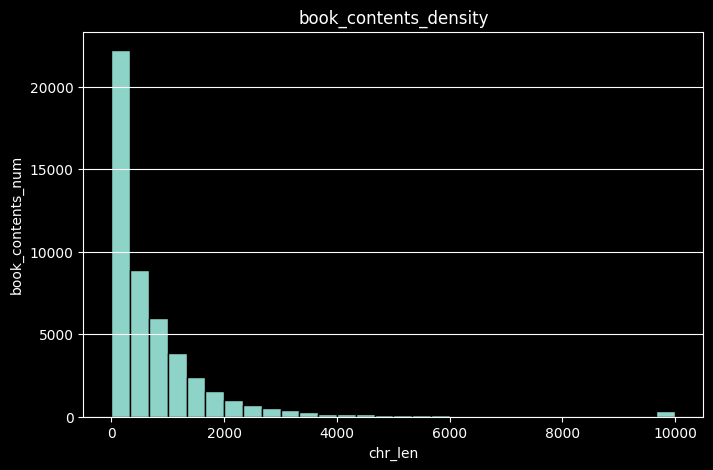

4436


In [ ]:
df["book_contents_char_count"] = df["목차"].apply(
    lambda x: len(str(x)) if pd.notna(x) else 0
)


plt.figure(figsize=(8, 5))
plt.hist(df["book_contents_char_count"].dropna(), bins=30, edgecolor="black")
plt.title("book_contents_density")
plt.xlabel("chr_len")
plt.ylabel("book_contents_num")
plt.grid(axis="y")
plt.show()
print(df[df["book_contents_char_count"] > 2000].shape[0])